<a href="https://colab.research.google.com/github/Heemyk/BiomechSAE/blob/main/SAE_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
commit = "08efeb9" # Stable commit # for probe steering
commit2 = "4965b94"
# get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/montemac/algebraic_value_editing.git@{commit}') # for probe steering
get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/openai/sparse_autoencoder.git@{commit2}') # openai sparse autoencoder


  Cloning https://github.com/openai/sparse_autoencoder.git (to revision 4965b94) to /tmp/pip-req-build-m2u88mgv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/sparse_autoencoder.git /tmp/pip-req-build-m2u88mgv
  Running command git checkout -q 4965b94
  Resolved https://github.com/openai/sparse_autoencoder.git to commit 4965b94
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# ----------------------------------- IMPORTS -------------------------------------
import torch
import blobfile as bf
import sparse_autoencoder
# import transformers
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
sns.set_style("whitegrid")
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
from typing import List, Union, Tuple
from functools import partial
from transformer_lens.HookedTransformer import HookedTransformer

# for probe steering
# from algebraic_value_editing.completion_utils import print_n_comparisons
# from algebraic_value_editing.prompt_utils import RichPrompt, get_x_vector


# for methods
from torch.nn.utils.rnn import pad_sequence


LANGUAGE MODEL - GPT2

In [ ]:
model = HookedTransformer.from_pretrained("gpt2", center_writing_weights=False) # Using HookedTransformer, lets you add stuff more easily into specific layers
device = next(model.parameters()).device # idk what this does, not sure what the device is but it works, was copypasted from example code
print(model) # Prints models parameters
print(model.cfg.n_layers) # no of layers
prompt = "This is an example of a prompt that"
tokens = model.to_tokens(prompt)  # (1, n_tokens)
with torch.no_grad():
    logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): Ho

Probe steering - IGNORE, NOT NEEDED AND NOT GREAT RESULTS

In [ ]:
# # Shorten function calls
# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}
# get_x_vector_preset = partial(get_x_vector, pad_method="tokens_right",
#                               model=model,
#                               custom_pad_id=model.to_single_token(" "))

In [ ]:
# rich_prompts = [#*get_x_vector_preset(prompt1="Geese killed my father", prompt2="Geese didn't kill my father", coeff=1, act_name=14),
#                 *get_x_vector_preset(prompt1="francais", prompt2="english", coeff=15, act_name=8),]

# print_n_comparisons(prompt="Yesterday, my son brought home a pet ",
#                     tokens_to_generate=80, rich_prompts=rich_prompts,
#                     num_comparisons=15, seed=0, **default_kwargs)

PROMPT EXPERIMENTATION

In [ ]:
print(model.to_tokens(" Czech")) # Example of how GPT-2 tokenizes words

tensor([[50256, 16639]], device='cuda:0')


In [ ]:
# GLOBALS - TO EASILY CHANGE WHERE IN THE MODEL WE ARE LOOKING (will refactor into class later, but that will make it harder to edit stuff on the fly so will leave as globals for now)
layer_index_global = 8
location_global = "resid_post_mlp"

transformer_lens_loc_dict = lambda layer_index : {
      "mlp_post_act": f"blocks.{layer_index}.mlp.hook_post",
      "resid_delta_attn": f"blocks.{layer_index}.hook_attn_out",
      "resid_post_attn": f"blocks.{layer_index}.hook_resid_mid",
      "resid_delta_mlp": f"blocks.{layer_index}.hook_mlp_out",
      "resid_post_mlp": f"blocks.{layer_index}.hook_resid_post",
  } # Used for navigating transformer. Takes in layer_index and gives a path to hook within language model


In [ ]:
# Methods

def find_recons(tokens, autoencoder, layer_index = layer_index_global, location = location_global):
  with torch.no_grad():
      logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True) # runs the model with the tokens, and caches all the model info
  transformer_lens_loc = transformer_lens_loc_dict(layer_index)[location] # specific bit in the model to reconstruct, specificied by the layer_index (there are 12) and location
  input_tensor = activation_cache[transformer_lens_loc] # Gets the cached info at this bit
  input_tensor_ln = input_tensor # copies, don't want to affect original
  with torch.no_grad():
      latent_activations, info = autoencoder.encode(input_tensor_ln) # projects into sparse basis (halfway through structure)
      reconstructed_activations = autoencoder.decode(latent_activations, info) # full way, not needed
  return latent_activations # shape is (no_of_tokens_in_input, no_of_features_in_latent_space). For each token, it will give the sparse decomposition from feedforwarding everything up to it and getting the corresponding activations


def split_by_element(token_to_split, element = " I"): # NOT USED RN, IGNORE
  # -------------- example implementation ---------------------
  # inputs: token_to_split = "James and I went to the park but I was unhappy so I went home.", element = " I"
  # returns: ([to_tokens("James and I"), to_tokens("James and I went to the park but I"), to_tokens(James and I went to the park but I was unhappy so I)])

  target_element = model.to_tokens(element)[0][-1].item() # gets token representation of element to look for, defaults to look for " I"
  # target_element = 314
  tokens_split = torch.nn.utils.rnn.pad_sequence([token_to_split[0][:i+1] for i in range(token_to_split.shape[-1]) if token_to_split[0][i].item() == target_element], batch_first=True) # Finds instances of elements in original code and cumulatively appends sublist
  return tokens_split



def get_split_element_idxs(token_to_split, element = " I"):
  target_element = model.to_tokens(element)[0][-1].item()
  tokens_split_idxs = torch.tensor([i for i in range(token_to_split.shape[-1]) if token_to_split[0][i].item() == target_element])
  return tokens_split_idxs # returns indices of where element is present in token_to_split



def get_time_signal_data(tokens, layer_index = layer_index_global, location = location_global, return_autoenc = False):
  with bf.BlobFile(sparse_autoencoder.paths.v5_32k(location, layer_index), mode="rb") as f: # Opens OpenAIs v5_32k sparse autoencoder pretrained model
      state_dict = torch.load(f)
      autoencoder = sparse_autoencoder.Autoencoder.from_state_dict(state_dict) # builds autoencoder model from pretrained saved data
      autoencoder.to(device)

  lst_of_latents = find_recons(tokens, autoencoder = autoencoder, layer_index=layer_index_global, location=location) # gets the latent representations of the tokens, and by nature of the autoencoder they provide (see find_recons return type), this is sequential
  print(f"Signal data shape: {lst_of_latents.shape}") # (no_of_tokens_in_input, no_of_features_in_latent_space)
  if return_autoenc:
    return lst_of_latents, autoencoder # flag for autoencoder along with latent data to avoid opening and loading multiple times (to make faster)
  return torch.Tensor.cpu(lst_of_latents)


def analyse_PCA(token, splitter = " I", difference = False, layer_index = layer_index_global, location = location_global):
  data_to_analyse = get_time_signal_data(token, layer_index=layer_index, location=location) # gets time signal data, looks at the last layer (layer_index_global) and defaults to resid_post_mlp part
  idx_data = get_split_element_idxs(token, splitter) # gets indices of where "splitter" word is present in text
  if difference:
    data_parsed = data_to_analyse[idx_data] - data_to_analyse[torch.add(idx_data, -1)] # looks at change in MLP layer outputs before "splitter" and after
  else:
    data_parsed = data_to_analyse[torch.add(idx_data, -1)] # looks at output after
  _, _, V = torch.pca_lowrank(data_parsed) # pca, gives U, S, V where operator = USV^T after centering
  eigvecs = V.T
  # print(f"Eigenvalues are: {eigvals}")
  # print(f"Eigenvectors are: {V.T}")
  for ye in eigvecs:
    plt.plot(ye, alpha = 0.2) # plots eigenvectors, plots value on y and dimension (32k) on x



def analyse_PCA_eigvals(token, splitter = " I", difference = False, layer_index = layer_index_global, location = location_global): # plots eigenvalues against prinipal no
  data_to_analyse = get_time_signal_data(token, layer_index=layer_index, location=location)
  idx_data = get_split_element_idxs(token, splitter)
  if difference:
    data_parsed = data_to_analyse[idx_data] - data_to_analyse[torch.add(idx_data, -1)]
  else:
    data_parsed = data_to_analyse[torch.add(idx_data, -1)]
  _, S, _ = torch.pca_lowrank(data_parsed)
  eigvals = S**2 / (data_parsed.size(0) - 1)
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(eigvals) + 1), eigvals, 'o-', markersize=8, linewidth=2)
  plt.title('Eigenvalues vs Principal Component Number')
  plt.xlabel('Principal Component Number')
  plt.ylabel('Eigenvalue')
  plt.grid(True)
  # plt.show()
  # plt.plot()



def analyse_dim_freqs(token, splitter = " I", onehot = False, temp = 1, layer_index = layer_index_global, location = location_global):
  data_to_analyse = get_time_signal_data(token, layer_index=layer_index, location=location) # gets time signal data
  idx_data = get_split_element_idxs(token, splitter) # gets indexes of where word is present
  data_parsed =  data_to_analyse[torch.add(idx_data, -1)]  # looks at last layer (layer_index_global) of word before token (ie predictions) and gets sparse decompositions of these for all instances in text signal
  dp_non_zeros = (data_parsed!=0).int() if onehot else data_parsed # if onehot, then look at when a dimension is turned on, and ignore the actual value (frequency). Not
  avg_freqs = torch.mean((dp_non_zeros / dp_non_zeros.sum(dim=-1).unsqueeze(-1)), dim = 0) # for a given decomposition (1 x 32k), we normalize this so it adds to 1 (probability distribution). We then average along all decompositions (no of decompositions is no of instances of "splitter" word in text)
  plt.plot(torch.nn.functional.softmax(avg_freqs/temp), alpha = 0.2) # Uses a softmax with temperature to bring out spikes in dimension more, just for playing around.


In [ ]:
#chess experiment
"""
prompt1 = Beneath the golden sun’s embrace so warm,
Where twilight weaves its magic, soft and calm,
The whispering winds in fields of green transform,
And dance with shadows in a twilight charm.

The stars emerge as day begins to wane,
A quiet lullaby within the night,
As dreams take flight and stars their paths regain,
The world is hushed in nature’s gentle light."""

prompt1 = """d4 Nf6
c4 e6
Nc3 Bb4
Qc2 O-O
Nf3 d5
Bg5 h6
Bh4 c5
dxc5 dxc4
e3 Nbd7
Bxc4 Qa5
O-O Qxc5
Bb3 Bxc3
bxc3 b6
Rfd1 Bb7
Rd4 Rac8
Rad1 Rc7
Bg3 e5
R4d2 Re8
h3 Qc6
Qf5 g6
Qb1 Kg7
a4 Qxc3
Qa2 Re7
Kh2 Qc6
a5 b5
Qa1 Ne4
Rd5 Nxg3
fxg3 Qc3
Qa2 Qxe3
Rxb5 Nf6
Qa3 Qe2
Re1 Qxb5
Ba4 Qc5
Qxc5 Rxc5
Nd2 e4"""
tokens1 = model.to_tokens(prompt1)

move1 = get_time_signal_data(tokens1, layer_index_global, location_global)


Signal data shape: torch.Size([224, 32768])


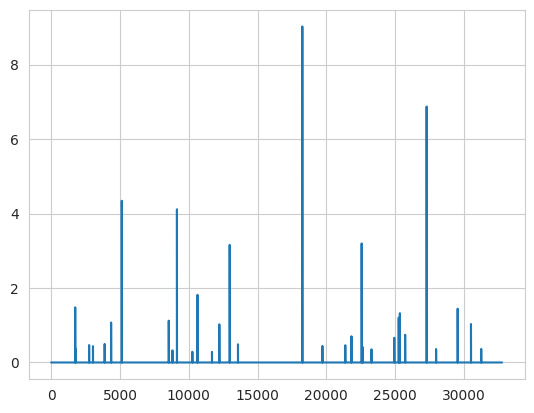

In [ ]:
plt.plot(move1[1])

Signal data shape: torch.Size([90, 32768])


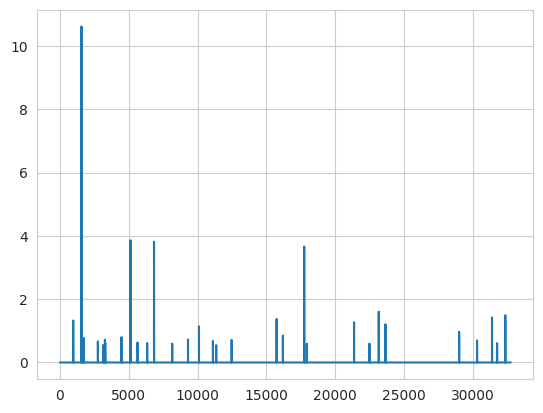

In [ ]:
prompt1 = """Amidst the bustling city streets, where the rhythm of life never seems to pause, there exists a hidden park, a serene oasis surrounded by towering skyscrapers. Here, the sounds of traffic fade into the background, replaced by the soothing rustle of leaves and the occasional chirp of a sparrow. This tranquil space offers a brief respite, allowing city dwellers to reconnect with nature and find a moment of calm."""
tokens1 = model.to_tokens(prompt1)

move1 = get_time_signal_data(tokens1, layer_index_global, location_global)

plt.plot(move1[1])

Signal data shape: torch.Size([4, 32768])


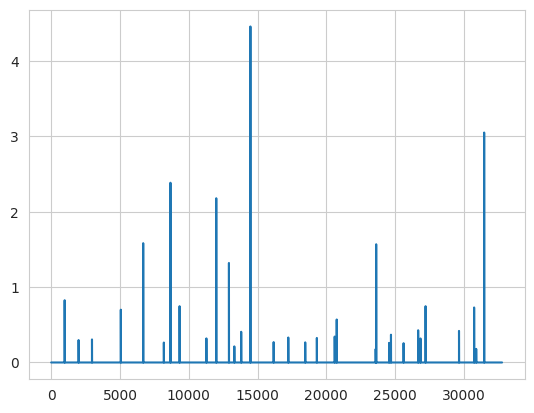

In [ ]:
prompt1 = "I am bored"
tokens1 = model.to_tokens(prompt1)

move1 = get_time_signal_data(tokens1, layer_index_global, location_global)

plt.plot(move1[1])

Signal data shape: torch.Size([37, 32768])


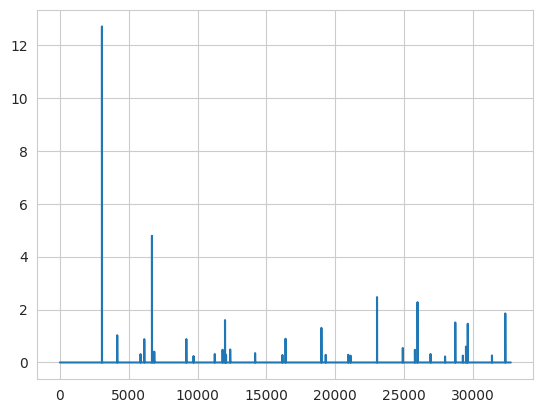

In [ ]:
prompt1 = "1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. c3 Nf6 5. d4 exd4"
tokens1 = model.to_tokens(prompt1)

move1 = get_time_signal_data(tokens1, layer_index_global, location_global)

plt.plot(move1[1])

Signal data shape: torch.Size([1024, 32768])


<ipython-input-6-458bcc48a2db>:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(torch.nn.functional.softmax(avg_freqs/temp), alpha = 0.2) # Uses a softmax with temperature to bring out spikes in dimension more, just for playing around.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

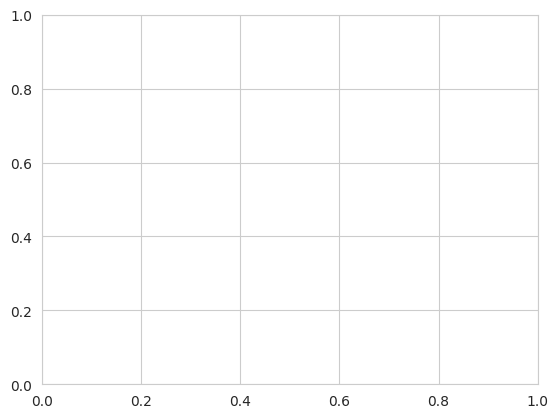

In [ ]:
#-------------------------------------------------- INITIAL TESTS --------------------------------------------------------


prompt1 = """Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”

    Ah, distinctly I remember it was in the bleak December;
And each separate dying ember wrought its ghost upon the floor.
    Eagerly I wished the morrow;—vainly I had sought to borrow
    From my books surcease of sorrow—sorrow for the lost Lenore—
For the rare and radiant maiden whom the angels name Lenore—
            Nameless here for evermore.

    And the silken, sad, uncertain rustling of each purple curtain
Thrilled me—filled me with fantastic terrors never felt before;
    So that now, to still the beating of my heart, I stood repeating
    “’Tis some visitor entreating entrance at my chamber door—
Some late visitor entreating entrance at my chamber door;—
            This it is and nothing more.”

    Presently my soul grew stronger; hesitating then no longer,
“Sir,” said I, “or Madam, truly your forgiveness I implore;
    But the fact is I was napping, and so gently you came rapping,
    And so faintly you came tapping, tapping at my chamber door,
That I scarce was sure I heard you”—here I opened wide the door;—
            Darkness there and nothing more.

    Deep into that darkness peering, long I stood there wondering, fearing,
Doubting, dreaming dreams no mortal ever dared to dream before;
    But the silence was unbroken, and the stillness gave no token,
    And the only word there spoken was the whispered word, “Lenore?”
This I whispered, and an echo murmured back the word, “Lenore!”—
            Merely this and nothing more.

    Back into the chamber turning, all my soul within me burning,
Soon again I heard a tapping somewhat louder than before.
    “Surely,” said I, “surely that is something at my window lattice;
      Let me see, then, what thereat is, and this mystery explore—
Let my heart be still a moment and this mystery explore;—
            ’Tis the wind and nothing more!”

    Open here I flung the shutter, when, with many a flirt and flutter,
In there stepped a stately Raven of the saintly days of yore;
    Not the least obeisance made he; not a minute stopped or stayed he;
    But, with mien of lord or lady, perched above my chamber door—
Perched upon a bust of Pallas just above my chamber door—
            Perched, and sat, and nothing more.

Then this ebony bird beguiling my sad fancy into smiling,
By the grave and stern decorum of the countenance it wore,
“Though thy crest be shorn and shaven, thou,” I said, “art sure no craven,
Ghastly grim and ancient Raven wandering from the Nightly shore—
Tell me what thy lordly name is on the Night’s Plutonian shore!”
            Quoth the Raven “Nevermore.”

    Much I marvelled this ungainly fowl to hear discourse so plainly,
Though its answer little meaning—little relevancy bore;
    For we cannot help agreeing that no living human being
    Ever yet was blessed with seeing bird above his chamber door—
Bird or beast upon the sculptured bust above his chamber door,
            With such name as “Nevermore.”

    But the Raven, sitting lonely on the placid bust, spoke only
That one word, as if his soul in that one word he did outpour.
    Nothing farther then he uttered—not a feather then he fluttered—
    Till I scarcely more than muttered “Other friends have flown before—
On the morrow he will leave me, as my Hopes have flown before.”
            Then the bird said “Nevermore.”

    Startled at the stillness broken by reply so aptly spoken,
“Doubtless,” said I, “what it utters is its only stock and store
    Caught from some unhappy master whom unmerciful Disaster
    Followed fast and followed faster till his songs one burden bore—
Till the dirges of his Hope that melancholy burden bore
            Of ‘Never—nevermore’.”

    But the Raven still beguiling all my fancy into smiling,
Straight I wheeled a cushioned seat in front of bird, and bust and door;
    Then, upon the velvet sinking, I betook myself to linking
    Fancy unto fancy, thinking what this ominous bird of yore—
What this grim, ungainly, ghastly, gaunt, and ominous bird of yore
            Meant in croaking “Nevermore.”

    This I sat engaged in guessing, but no syllable expressing
To the fowl whose fiery eyes now burned into my bosom’s core;
    This and more I sat divining, with my head at ease reclining
    On the cushion’s velvet lining that the lamp-light gloated o’er,
But whose velvet-violet lining with the lamp-light gloating o’er,
            She shall press, ah, nevermore!

    Then, methought, the air grew denser, perfumed from an unseen censer
Swung by Seraphim whose foot-falls tinkled on the tufted floor.
    “Wretch,” I cried, “thy God hath lent thee—by these angels he hath sent thee
    Respite—respite and nepenthe from thy memories of Lenore;
Quaff, oh quaff this kind nepenthe and forget this lost Lenore!”
            Quoth the Raven “Nevermore.”

    “Prophet!” said I, “thing of evil!—prophet still, if bird or devil!—
Whether Tempter sent, or whether tempest tossed thee here ashore,
    Desolate yet all undaunted, on this desert land enchanted—
    On this home by Horror haunted—tell me truly, I implore—
Is there—is there balm in Gilead?—tell me—tell me, I implore!”
            Quoth the Raven “Nevermore.”

    “Prophet!” said I, “thing of evil!—prophet still, if bird or devil!
By that Heaven that bends above us—by that God we both adore—
    Tell this soul with sorrow laden if, within the distant Aidenn,
    It shall clasp a sainted maiden whom the angels name Lenore—
Clasp a rare and radiant maiden whom the angels name Lenore.”
            Quoth the Raven “Nevermore.”

    “Be that word our sign of parting, bird or fiend!” I shrieked, upstarting—
“Get thee back into the tempest and the Night’s Plutonian shore!
    Leave no black plume as a token of that lie thy soul hath spoken!
    Leave my loneliness unbroken!—quit the bust above my door!
Take thy beak from out my heart, and take thy form from off my door!”
            Quoth the Raven “Nevermore.”

    And the Raven, never flitting, still is sitting, still is sitting
On the pallid bust of Pallas just above my chamber door;
    And his eyes have all the seeming of a demon’s that is dreaming,
    And the lamp-light o’er him streaming throws his shadow on the floor;
And my soul from out that shadow that lies floating on the floor
            Shall be lifted—nevermore!

""" # The Raven, Edgar Allen Poe

prompt2= """In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.
"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had."
He didn't say any more but we've always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that. In consequence I'm inclined to reserve all judgments, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college I was unjustly accused of being a politician, because I was privy to the secret griefs of wild, unknown men. Most of the confidences were unsought—frequently I have feigned sleep, preoccupation, or a hostile levity when I realized by some unmistakable sign that an intimate revelation was quivering on the horizon—for the intimate revelations of young men or at least the terms in which they express them are usually plagiaristic and marred by obvious suppressions. Reserving judgments is a matter of infinite hope. I am still a little afraid of missing something if I forget that, as my father snobbishly suggested, and I snobbishly repeat, a sense of the fundamental decencies is parcelled out unequally at birth.
And, after boasting this way of my tolerance, I come to the admission that it has a limit. Conduct may be founded on the hard rock or the wet marshes but after a certain point I don't care what it's founded on. When I came back from the East last autumn I felt that I wanted the world to be in uniform and at a sort of moral attention forever; I wanted no more riotous excursions with privileged glimpses into the human heart. Only Gatsby, the man who gives his name to this book, was exempt from my reaction—Gatsby who represented everything for which I have an unaffected scorn. If personality is an unbroken series of successful gestures, then there was something gorgeous about him, some heightened sensitivity to the promises of life, as if he were related to one of those intricate machines that register earthquakes ten thousand miles away. This responsiveness had nothing to do with that flabby impressionability which is dignified under the name of the "creative temperament"—it was an extraordinary gift for hope, a romantic readiness such as I have never found in any other person and which it is not likely I shall ever find again. No—Gatsby turned out all right at the end; it is what preyed on Gatsby, what foul dust floated in the wake of his dreams that temporarily closed out my interest in the abortive sorrows and short-winded elations of men.
My family have been prominent, well-to-do people in this middle-western city for three generations. The Carraways are something of a clan and we have a tradition that we're descended from the Dukes of Buccleuch, but the actual founder of my line was my grandfather's brother who came here in fifty-one, sent a substitute to the Civil War and started the wholesale hardware business that my father carries on today.
I never saw this great-uncle but I'm supposed to look like him—with special reference to the rather hard-boiled painting that hangs in Father's office. I graduated from New Haven in 1915, just a quarter of a century after my father, and a little later I participated in that delayed Teutonic migration known as the Great War. I enjoyed the counter-raid so thoroughly that I came back restless. Instead of being the warm center of the world the middle-west now seemed like the ragged edge of the universe—so I decided to go east and learn the bond business. Everybody I knew was in the bond business so I supposed it could support one more single man. All my aunts and uncles talked it over as if they were choosing a prep-school for me and finally said, "Why—ye-es" with very grave, hesitant faces. Father agreed to finance me for a year and after various delays I came east, permanently, I thought, in the spring of twenty-two.
The practical thing was to find rooms in the city but it was a warm season and I had just left a country of wide lawns and friendly trees, so when a young man at the office suggested that we take a house together in a commuting town it sounded like a great idea. He found the house, a weather beaten cardboard bungalow at eighty a month, but at the last minute the firm ordered him to Washington and I went out to the country alone. I had a dog, at least I had him for a few days until he ran away, and an old Dodge and a Finnish woman who made my bed and cooked breakfast and muttered Finnish wisdom to herself over the electric stove.
""" # The Great Gatsby, F.Scott Fitzgerals

prompt3 = """Thank you for this wonderful welcome. Thank you to the people of Prague. And thank you to
the people of the Czech Republic. Today, I am proud to stand here with you in the middle of
this great city, in the center of Europe. And - to paraphrase one my predecessors - I am also
proud to be the man who brought Michelle Obama to Prague.
I have learned over many years to appreciate the good company and good humor of the Czech
people in my hometown of Chicago. Behind me is a statue of a hero of the Czech people -
Tomas Masaryk. In 1918, after America had pledged its support for Czech independence,
Masaryk spoke to a crowd in Chicago that was estimated to be over 100.000. I don't think I
can match Masaryk's record, but I'm honored to follow his footsteps from Chicago to Prague.
For over a thousand years, Prague has set itself apart from any other city in any other place.
You have known war and peace. You have seen empires rise and fall. You have led
revolutions in the arts and science, in politics and poetry. Through it all, the people of Prague
have insisted on pursuing their own path, and defining their own destiny. And this city - this
Golden City which is both ancient and youthful - stands as a living monument to your
unconquerable spirit.
When I was born, the world was divided, and our nations were faced with very different
circumstances. Few people would have predicted that someone like me would one day
become an American President. Few people would have predicted that an American President
would one day be permitted to speak to an audience like this in Prague. And few would have
imagined that the Czech Republic would become a free nation, a member of NATO, and a
leader of a united Europe. Those ideas would have been dismissed as dreams.
We are here today because enough people ignored the voices who told them that the world
could not change.
We are here today because of the courage of those who stood up - and took risks - to say that
freedom is a right for all people, no matter what side of a wall they live on, and no matter
what they look like. """ # Obama - speech to Prague (https://vlada.gov.cz/assets/media-centrum/aktualne/Speech-of-Barack-Obama.pdf)

tokens1 = model.to_tokens(prompt1) # 1024 tokens (Tensor(1, 1024))
tokens2 = model.to_tokens(prompt2) # 1024 tokens
tokens3 = model.to_tokens(prompt3)


# -------------------------- Info --------------------------
# For all these tests, we look at layer 11, and the resid_post_mlp bit, as specified in globals. Using OpenAI v5_32k SAE and GPT-2. Comment out whatever below
# ------------------------------------------------------------

# analyse_dim_freqs(tokens1)
analyse_dim_freqs(tokens2, splitter = " I", onehot = False, temp = 1)
analyse_dim_freqs(tokens3, splitter = " I", onehot = False, temp = 1)
analyse_dim_freqs(tokens3, splitter = " Czech", onehot = False, temp = 1)
# analyse_PCA(tokens1, splitter = " I")

# analyse_PCA(tokens2, splitter = " I")

# analyse_PCA_eigvals(tokens1, splitter = " I")

# analyse_PCA_eigvals(tokens2, splitter = " I")

In [ ]:
def plot_ts_cov(promptsmall, probes = []): # Gets signal (ie list of tokens at successive 'timesteps', and plots covariance). Probes are standalone words run through model for comparisons and correspond to the block at the end in visualisations
  promptsmalltokens = model.to_tokens(promptsmall)
  # for i in (promptsmalltokens[0]):
  #   print(model.to_string(i)) # prints tokens

  promptsmalltoken_strings = [model.to_string(i.item()) for i in promptsmalltokens[0]] # for labelling plot with tokens. Note labels actually correspond to signal up until word, not just the word on its own, but for visualisation we just plot the word on the axes

  if len(probes) != 0: # if we are also plotting probes
    promptsmalldata, autoenc = get_time_signal_data(promptsmalltokens, return_autoenc = True) # reuses same 'autoenc' later for speed. Note signals are sequential

    probedata = []
    for probe in probes:
      probetokens = model.to_tokens(probe)
      probedata.append(find_recons(probetokens, autoenc))
      for i in probetokens[0]:
        promptsmalltoken_strings.append(model.to_string(i))
    probedata = torch.stack([row.view(-1) for tensor in probedata for row in tensor], dim=0)
    # ^ processes the probes so they can be dotted and visualised nicely

    promptsmallcovariance = torch.cov(torch.cat((promptsmalldata, probedata), 0)) # calculates covariance
  else: # if no probes
    promptsmalldata = get_time_signal_data(promptsmalltokens, return_autoenc = False)
    promptsmallcovariance = torch.corrcoef(promptsmalldata)

  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(torch.Tensor.cpu(promptsmallcovariance), xticklabels=promptsmalltoken_strings, yticklabels=promptsmalltoken_strings, cmap = "viridis")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x labels for better readability
  plt.title("Covariance Matrix Heatmap")
  plt.show()

Signal data shape: torch.Size([52, 32768])


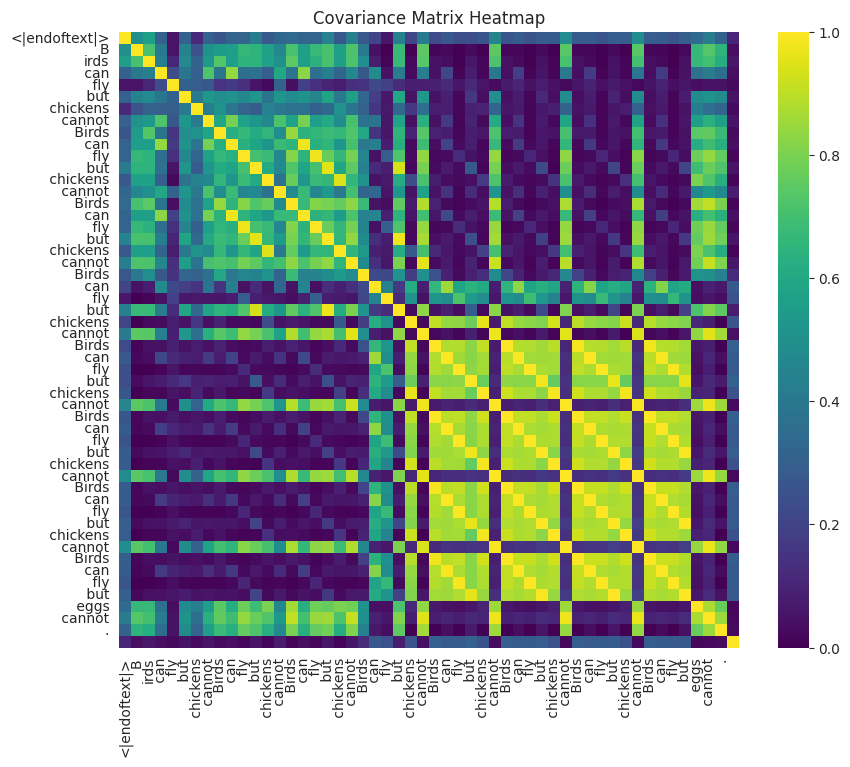

In [ ]:
# --------------------------------EXPERIMENTS----------------------------------------------
plot_ts_cov(
promptsmall = """Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but eggs cannot.
""")

In [ ]:
plot_ts_cov(
    promptsmall = """
    2+2=4
    2+3=5
    5+7=12
    6+2=8
    5+2=7
    4+2=6
    1+4=5
    3+8=11
    9+1=10
    1+5=6
    2+2=4
    2+7=9
    5+6=11
    2+4=6
    1+8=9
    6+7=13
    7+8=15
    1+3=4
    4+4=8
    """
)
plot_ts_cov(
    promptsmall = """
    2+2=4
    2+3=5
    5+7=12
    6+2=6
    5+2=7
    4+2=6
    1+4=5
    3+8=11
    9+1=10
    1+5=6
    2+2=4
    2+7=9
    5+6=11
    2+4=6
    1+8=9
    6+7=13
    7+8=15
    1+3=4
    4+4=8
    """
)#6+2=6
plot_ts_cov(
    promptsmall = """
    2+2=4
    2+3=5
    5+7=12
    6+2=8
    5+2=7
    4+2=6
    1+4=5
    3+8=11
    9+1=10
    1+5=6
    2+2=4
    2+7=9
    5+6=11
    2+4=6
    1+8=9
    6+7=13
    7+8=10
    1+3=4
    4+4=8
    """
)#7+8=10

Signal data shape: torch.Size([177, 32768])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x800 with 0 Axes>

Note: For third experiment (mistake later on), bar is present just after 7+8=10 - result is uncorrelated with beforehand? suggests learning truth maybe

Nonlinear Dimensionality Reduction

Signal data shape: torch.Size([48, 32768])


<ipython-input-25-06176a40e5a0>:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Token no')


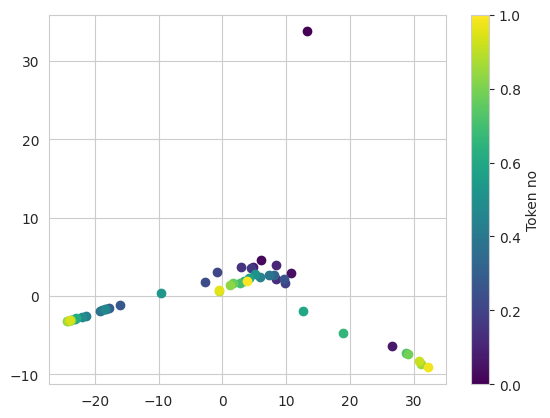

In [ ]:
from sklearn.manifold import SpectralEmbedding, Isomap

# Functions
def lap_eig(token, dim = 2):
  X = get_time_signal_data(model.to_tokens(token))
  embedding = SpectralEmbedding(n_components = dim)
  X_transformed = embedding.fit_transform(X)
  X_transformed.shape
  return X_transformed

def isomap(token, dim = 2, n_neighbors = 5):
  X = get_time_signal_data(model.to_tokens(token))
  embedding = Isomap(n_components = dim, n_neighbors = n_neighbors)
  X_transformed = embedding.fit_transform(X)
  X_transformed.shape
  return X_transformed


def plot2d_col_grad(data):
  no_points = data.shape[0]
  cmap = plt.get_cmap("viridis")
  colors = np.linspace(0, 1, no_points)
  for i in range(no_points):
    plt.scatter(data[i][0], data[i][1], color = cmap(colors[i]))
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Token no')


def plot3d_col_grad(data):
  fig = plt.figure()
  ax = fig.add_subplot(projection = "3d")
  no_points = data.shape[0]
  cmap = plt.get_cmap("viridis")
  colors = np.linspace(0, 1, no_points)
  for i in range(no_points):
    ax.scatter(data[i][0], data[i][1], data[i][2], color = cmap(colors[i]))
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Token no')



Prompts

In [ ]:

p_birds = """Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but chickens cannot Birds can fly but eggs cannot.
"""
p_greetings1 = """Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So? Hello, Hi, So?"""

p_greetings2 = """Hello, Hi, Hello, Hi, Hello, Hi, Hello, Hi, Hello, Hi, Hello, Hi, Hello, Hi, Hello, Hi"""

p_greetings2 = """Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios, Bye, Adios"""

p_addition = """
    2+2=4
    2+3=5
    5+7=12
    6+2=8
    5+2=7
    4+2=6
    1+4=5
    3+8=11
    9+1=10
    1+5=6
    2+2=4
    2+7=9
    5+6=11
    2+4=6
    1+8=9
    6+7=13
    7+8=15
    1+3=4
    4+4=8
    """

p_raven = """Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”

    Ah, distinctly I remember it was in the bleak December;
And each separate dying ember wrought its ghost upon the floor.
    Eagerly I wished the morrow;—vainly I had sought to borrow
    From my books surcease of sorrow—sorrow for the lost Lenore—
For the rare and radiant maiden whom the angels name Lenore—
            Nameless here for evermore.

    And the silken, sad, uncertain rustling of each purple curtain
Thrilled me—filled me with fantastic terrors never felt before;
    So that now, to still the beating of my heart, I stood repeating
    “’Tis some visitor entreating entrance at my chamber door—
Some late visitor entreating entrance at my chamber door;—
            This it is and nothing more.”

    Presently my soul grew stronger; hesitating then no longer,
“Sir,” said I, “or Madam, truly your forgiveness I implore;
    But the fact is I was napping, and so gently you came rapping,
    And so faintly you came tapping, tapping at my chamber door,
That I scarce was sure I heard you”—here I opened wide the door;—
            Darkness there and nothing more.

    Deep into that darkness peering, long I stood there wondering, fearing,
Doubting, dreaming dreams no mortal ever dared to dream before;
    But the silence was unbroken, and the stillness gave no token,
    And the only word there spoken was the whispered word, “Lenore?”
This I whispered, and an echo murmured back the word, “Lenore!”—
            Merely this and nothing more.

    Back into the chamber turning, all my soul within me burning,
Soon again I heard a tapping somewhat louder than before.
    “Surely,” said I, “surely that is something at my window lattice;
      Let me see, then, what thereat is, and this mystery explore—
Let my heart be still a moment and this mystery explore;—
            ’Tis the wind and nothing more!”

    Open here I flung the shutter, when, with many a flirt and flutter,
In there stepped a stately Raven of the saintly days of yore;
    Not the least obeisance made he; not a minute stopped or stayed he;
    But, with mien of lord or lady, perched above my chamber door—
Perched upon a bust of Pallas just above my chamber door—
            Perched, and sat, and nothing more.

Then this ebony bird beguiling my sad fancy into smiling,
By the grave and stern decorum of the countenance it wore,
“Though thy crest be shorn and shaven, thou,” I said, “art sure no craven,
Ghastly grim and ancient Raven wandering from the Nightly shore—
Tell me what thy lordly name is on the Night’s Plutonian shore!”
            Quoth the Raven “Nevermore.”

    Much I marvelled this ungainly fowl to hear discourse so plainly,
Though its answer little meaning—little relevancy bore;
    For we cannot help agreeing that no living human being
    Ever yet was blessed with seeing bird above his chamber door—
Bird or beast upon the sculptured bust above his chamber door,
            With such name as “Nevermore.”

    But the Raven, sitting lonely on the placid bust, spoke only
That one word, as if his soul in that one word he did outpour.
    Nothing farther then he uttered—not a feather then he fluttered—
    Till I scarcely more than muttered “Other friends have flown before—
On the morrow he will leave me, as my Hopes have flown before.”
            Then the bird said “Nevermore.”

    Startled at the stillness broken by reply so aptly spoken,
“Doubtless,” said I, “what it utters is its only stock and store
    Caught from some unhappy master whom unmerciful Disaster
    Followed fast and followed faster till his songs one burden bore—
Till the dirges of his Hope that melancholy burden bore
            Of ‘Never—nevermore’.”

    But the Raven still beguiling all my fancy into smiling,
Straight I wheeled a cushioned seat in front of bird, and bust and door;
    Then, upon the velvet sinking, I betook myself to linking
    Fancy unto fancy, thinking what this ominous bird of yore—
What this grim, ungainly, ghastly, gaunt, and ominous bird of yore
            Meant in croaking “Nevermore.”

    This I sat engaged in guessing, but no syllable expressing
To the fowl whose fiery eyes now burned into my bosom’s core;
    This and more I sat divining, with my head at ease reclining
    On the cushion’s velvet lining that the lamp-light gloated o’er,
But whose velvet-violet lining with the lamp-light gloating o’er,
            She shall press, ah, nevermore!

    Then, methought, the air grew denser, perfumed from an unseen censer
Swung by Seraphim whose foot-falls tinkled on the tufted floor.
    “Wretch,” I cried, “thy God hath lent thee—by these angels he hath sent thee
    Respite—respite and nepenthe from thy memories of Lenore;
Quaff, oh quaff this kind nepenthe and forget this lost Lenore!”
            Quoth the Raven “Nevermore.”

    “Prophet!” said I, “thing of evil!—prophet still, if bird or devil!—
Whether Tempter sent, or whether tempest tossed thee here ashore,
    Desolate yet all undaunted, on this desert land enchanted—
    On this home by Horror haunted—tell me truly, I implore—
Is there—is there balm in Gilead?—tell me—tell me, I implore!”
            Quoth the Raven “Nevermore.”

    “Prophet!” said I, “thing of evil!—prophet still, if bird or devil!
By that Heaven that bends above us—by that God we both adore—
    Tell this soul with sorrow laden if, within the distant Aidenn,
    It shall clasp a sainted maiden whom the angels name Lenore—
Clasp a rare and radiant maiden whom the angels name Lenore.”
            Quoth the Raven “Nevermore.”

    “Be that word our sign of parting, bird or fiend!” I shrieked, upstarting—
“Get thee back into the tempest and the Night’s Plutonian shore!
    Leave no black plume as a token of that lie thy soul hath spoken!
    Leave my loneliness unbroken!—quit the bust above my door!
Take thy beak from out my heart, and take thy form from off my door!”
            Quoth the Raven “Nevermore.”

    And the Raven, never flitting, still is sitting, still is sitting
On the pallid bust of Pallas just above my chamber door;
    And his eyes have all the seeming of a demon’s that is dreaming,
    And the lamp-light o’er him streaming throws his shadow on the floor;
And my soul from out that shadow that lies floating on the floor
            Shall be lifted—nevermore!

"""

p_mix = """If I can stop one heart from breaking,
I shall not live in vain;
If I can ease one life the aching,
Or cool one pain,
Or help one fainting robin
Unto his nest again,
I shall not live in vain.
The severe and afflicting loss, which the Nation has sustained by the death of his Majesty, my beloved Uncle, has developed upon me the duty of administering the Government of this empire. This awful responsibility is imposed upon me so suddenly and at so early a period of my Life, that I should feel myself utterly oppresses by the burthen, were I not sustained by the hope, the Divine Providence, which has called me to this work, will give me strength for the performance of it, and that I shall fins in the purity of my Intentions and in my zeal for the public welfare that support and those resources, which usually belong to a more mature age and to longer experience.
I place my firm reliance upon the wisdom of Parliament and upon the loyalty and affection of my People. I esteem it also a peculiar advantage, that I succeed to a Sovereign whose constant regard for the rights and Liberties of his Subjects and whose desire to promote the amelioration of the Laws and Institutions of the Country have rendered his name the object of general attachment and veneration. Educated in England under the tender and enlightened care of a most affectionate Mother I have learned from my Infancy to respect and love the Constitution of my native Country. It will be my unceasing study to maintain the reformed Religion as by Law established securing at the same time to all the full enjoyment of religious liberty, and I shall steadily protect the rights and promote to the utmost of my Power the happiness and welfare of all Classes of my Subjects.
    """


p_poem_small = """If I can stop one heart from breaking,
I shall not live in vain;
If I can ease one life the aching,
Or cool one pain,
Or help one fainting robin
Unto his nest again,
I shall not live in vain."""


p_obama = """Thank you for this wonderful welcome. Thank you to the people of Prague. And thank you to
the people of the Czech Republic. Today, I am proud to stand here with you in the middle of
this great city, in the center of Europe. And - to paraphrase one my predecessors - I am also
proud to be the man who brought Michelle Obama to Prague.
I have learned over many years to appreciate the good company and good humor of the Czech
people in my hometown of Chicago. Behind me is a statue of a hero of the Czech people -
Tomas Masaryk. In 1918, after America had pledged its support for Czech independence,
Masaryk spoke to a crowd in Chicago that was estimated to be over 100.000. I don't think I
can match Masaryk's record, but I'm honored to follow his footsteps from Chicago to Prague.
For over a thousand years, Prague has set itself apart from any other city in any other place.
You have known war and peace. You have seen empires rise and fall. You have led
revolutions in the arts and science, in politics and poetry. Through it all, the people of Prague
have insisted on pursuing their own path, and defining their own destiny. And this city - this
Golden City which is both ancient and youthful - stands as a living monument to your
unconquerable spirit.
When I was born, the world was divided, and our nations were faced with very different
circumstances. Few people would have predicted that someone like me would one day
become an American President. Few people would have predicted that an American President
would one day be permitted to speak to an audience like this in Prague. And few would have
imagined that the Czech Republic would become a free nation, a member of NATO, and a
leader of a united Europe. Those ideas would have been dismissed as dreams.
We are here today because enough people ignored the voices who told them that the world
could not change.
We are here today because of the courage of those who stood up - and took risks - to say that
freedom is a right for all people, no matter what side of a wall they live on, and no matter
what they look like. """ # Obama - speech to Prague (https://vlada.gov.cz/assets/media-centrum/aktualne/Speech-of-Barack-Obama.pdf)




Tests

In [ ]:
# p1_transformed3d = lap_eig(p_repetition, dim = 3)
# p2_transformed3d = lap_eig(p_repetition2, dim = 3)


# plt.plot(p1_transformed[:,0], p1_transformed[:,1], "b.")
# plt.plot(p2_transformed[:,0], p2_transformed[:,1], "r.")

# fig = plt.figure()
# ax = fig.add_subplot(projection = "3d")
# ax.scatter(p2_transformed3d[:,0], p2_transformed3d[:,1], p2_transformed3d[:,2], "r.")
# ax.scatter(p1_transformed3d[:,0], p1_transformed3d[:,1], p1_transformed3d[:,2], "b.")
# p3_transformed2d = lap_eig(p3, dim = 2)
# p2_transformed2d = lap_eig(p_repetition2, dim = 2)


# plt.plot(p3_transformed2d[:,0], p3_transformed2d[:,1], "b.")
# plot2d_col_grad(p3_transformed2d)

# plot2d_col_grad(p2_transformed2d)

# p4_transformed = lap_eig(p4, dim = 2)
# p5_transformed = lap_eig(p5, dim = 2)

# plot2d_col_grad(p4_transformed)
# plot2d_col_grad(p5_transformed)

# p4_transformed_3d = lap_eig(p4, dim = 3)
# p5_transformed_3d = lap_eig(p5, dim = 3)

# prompt1_transformed = lap_eig(prompt1, dim = 2)
# plot2d_col_grad(prompt1_transformed)

# prompt1_isomap = isomap(p4, dim = 2, n_neighbors = 10)
# plot2d_col_grad(prompt1_isomap)


# prompt2_transformed = lap_eig(prompt2, dim = 3)
# plot3d_col_grad(prompt2_transformed)
# prompt2_f_transformed = lap_eig(prompt2_first, dim = 3)
# plot3d_col_grad(prompt2_f_transformed)

# prompt2_2d_tr = lap_eig(prompt2, dim = 2)
# plot2d_col_grad(prompt2_2d_tr)

# prompt3_transformed = lap_eig(prompt3, dim = 3)
# plot3d_col_grad(prompt3_transformed)

# plot2d_col_grad(prompt1_transformed)

# fig = plt.figure()
# ax = fig.add_subplot(projection = "3d")
# ax.scatter(prompt1_transformed[:,0], prompt1_transformed[:,1], prompt1_transformed[:,2], "r.")
# ax.scatter(p5_transformed_3d[:,0], p5_transformed_3d[:,1], p5_transformed_3d[:,2], "r.")

# fig = plt.figure()
# ax = fig.add_subplot(projection = "3d")
# ax.scatter(p4_transformed_3d[:,0], p4_transformed_3d[:,1], p4_transformed_3d[:,2], "r.")
# ax.scatter(p5_transformed_3d[:,0], p5_transformed_3d[:,1], p5_transformed_3d[:,2], "r.")



Logistic Classifier: - TAKES TOO LONG, HAVE TO RUN ON CLUSTER PROBABLY

In [ ]:
# imports
import datasets
from datasets import load_dataset # this is hugging faces dataset class
import random
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Prepping data

# Poetry
ds = load_dataset("biglam/gutenberg-poetry-corpus") # load gutenberg
df = ds['train'].to_pandas() # convert to pandas dataframe
df = df.groupby('gutenberg_id')['line'] \
     .apply(lambda x: '\n'.join(x)) \
     .reset_index(name='text') # combine individual lines
# print(df.iloc[0]['text'])

# Check the shape of the DataFrame
shape = df.shape

# Get the column names
columns = df.columns.tolist()

print(f"Shape of DataFrame: {shape}")
print(f"Column names: {columns}")

def training_example_generator(df, colname, min_token_depth = 50):
  text = df.sample(n=1)[colname]
  tokens = model.to_tokens(text)
  # print(tokens.shape)
  if tokens.shape[-1] > min_token_depth:
    token_index = random.randint(min_token_depth, tokens.shape[-1] - 1)
    return get_time_signal_data(tokens[:token_index])
  else:
    return None

def get_rand_samples(df, colname, no_samples = 1000, min_token_depth = 50):
  training_poetry = []
  counter = 0
  while counter < 1000:
    z = training_example_generator(df, colname = colname, min_token_depth = min_token_depth)
    if z != None:
      training_poetry.append(z)
      if (counter+1)%100 == 0:
        print((counter+1)/no_samples)
      counter+=1
  print(f"Done: No. of samples: {len(training_poetry)}")
  return training_poetry

poetry_samples = get_rand_samples(df, colname = 'text', no_samples = 1000)

# print(type(df))

# BBC News
ds2 = load_dataset("RealTimeData/bbc_news_alltime", "2017-01")
df2 = ds2['train'].to_pandas()
print(df2['content'][0])

news_samples = get_rand_samples(df2, colname = 'content', no_samples = 1000)


Shape of DataFrame: (1191, 2)
Column names: ['gutenberg_id', 'text']
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([

In [ ]:
# Model and training

# poetry_probs_sparse = torch.Tensor(list(map(get_time_signal_data, poetry_samples)))
# news_probs_sparse = torch.Tensor(list(map(get_time_signal_data, news_samples)))

poetry_probs_sparse = torch.Tensor(poetry_samples)
news_probs_sparse = torch.Tensor(news_samples)

n, d = 1000, 32768

poetry_labels = torch.ones((n, 1))
news_labels = torch.zeros((n, 1))

data = torch.vstack((poetry_probs_sparse, news_probs_sparse))
labels = torch.vstack((poetry_labels, news_labels))

# 3. Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

model = LogisticRegression(d)

# 4. Train the model
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Evaluate the model
with torch.no_grad():
    outputs = model(data)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([665, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([136, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([707, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([447, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data shape: torch.Size([1024, 32768])
Signal data sh

Attractor Stuff

In [ ]:
!pip install pyinform
!pip install tisean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 10.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tisean (from versions: none)
ERROR: No matching distribution found for tisean


In [ ]:
from sklearn.metrics import mutual_info_score
from pyinform import mutualinfo

def false_nearest_neighbors_multivariate(time_series, taus, max_dim, rtol=10, atol=2):
    """
    Compute the percentage of false nearest neighbors for a given multivariate time series.

    Parameters:
    time_series (array-like): The input multivariate time series data (shape: n_samples x n_features).
    taus (list): A list of time delays to use for each component of the time series.
    max_dim (int): The maximum embedding dimension to consider.
    rtol (float): The relative tolerance for identifying false neighbors.
    atol (float): The absolute tolerance for identifying false neighbors.

    Returns:
    fnn_percent (list): A list containing the percentage of false nearest neighbors for each embedding dimension.
    """
    n_samples, n_features = time_series.shape
    fnn_percent = []

    for d in range(1, max_dim + 1):
        embedded = []
        for i in range(n_samples - (d - 1) * max(taus)):
            vector = []
            for j in range(n_features):
                for k in range(d):
                    vector.append(time_series[i + k * taus[j], j])
            embedded.append(vector)
        embedded = np.array(embedded)

        fnn_count = 0
        total_pairs = 0

        for i in range(len(embedded) - 1):
            distances = np.linalg.norm(embedded[i + 1:] - embedded[i], axis=1)
            nearest_index = np.argmin(distances)
            nearest_distance = distances[nearest_index]

            if nearest_distance == 0:
                continue

            next_distance = np.linalg.norm(time_series[i + d * max(taus)] - time_series[nearest_index + d * max(taus)])
            if next_distance / nearest_distance > rtol or next_distance > atol:
                fnn_count += 1

            total_pairs += 1

        fnn_percent.append(fnn_count / total_pairs * 100)

    return fnn_percent

# Function to compute mutual information for different lags
def compute_mutual_information(time_series, max_lag):
    mi = []
    for lag in range(1, max_lag + 1):
        x = time_series[:-lag]
        y = time_series[lag:]
        mi.append(mutualinfo.mutual_info(x, y)) # or mutual_info_score(x, y)
    return mi

# Example for a single component
time_series = get_time_signal_data(model.to_tokens(p_raven))
# max_lag = 50  # Maximum lag to consider
# mi = compute_mutual_information(time_series, max_lag)

# # Plot mutual information vs. lag
# import matplotlib.pyplot as plt
# plt.plot(range(1, max_lag + 1), mi)
# plt.xlabel('Lag')
# plt.ylabel('Mutual Information')
# plt.show()

# # Choose the lag where mutual information first reaches a minimum or inflection point
# # optimal_lag = np.argmin(mi) + 1
optimal_lag = 12
print("Optimal Time Delay (Tau):", optimal_lag)

fnn_results = false_nearest_neighbors_multivariate(time_series, taus=[optimal_lag for _ in range(time_series.shape[-1])], max_dim=10)
embedding_dimension = next((i for i, v in enumerate(fnn_results) if v < 0.2), 10)

print("Optimal Embedding Dimension:", embedding_dimension)


Signal data shape: torch.Size([1024, 32768])
Optimal Time Delay (Tau): 12
